In [ ]:
#https://towardsdatascience.com/multi-label-classification-using-bert-roberta-xlnet-xlm-and-distilbert-with-simple-transformers-b3e0cda12ce5

In [ ]:
%%capture
!pip install simpletransformers
!pip install emoji

In [ ]:
# import some necessary sub libraries
import pandas as pd
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import f1_score, accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import os
import tarfile
import re
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     
#from google.colab import drive
#drive.mount('/content/drive')
from google.colab import files

def dict_to_df(d):
    df=pd.DataFrame(d.items())
    df.set_index(0, inplace=True)
    return df

def pack_model(model_path='',file_name=''):
  files = [files for root, dirs, files in os.walk(model_path)][0]
  with tarfile.open(file_name+ '.tar.gz', 'w:gz') as f:
    for file in files:
      f.add(f'{model_path}/{file}')

def unpack_model(model_name=''):
  tar = tarfile.open(f"{model_name}.tar.gz", "r:gz")
  tar.extractall()
  tar.close()

def prepare_results(result_dict):
  result_dict["f1_macro"] = result_dict["f1"]["f1_macro"]
  result_dict["f1_micro"] = result_dict["f1"]["f1_micro"]
  result_dict["f1_weighted"] = result_dict["f1"]["f1_weighted"]

  result_dict["precision_macro"] = result_dict["precision"]["precision_macro"]
  result_dict["precision_micro"] = result_dict["precision"]["precision_micro"]
  result_dict["precision_weighted"] = result_dict["precision"]["precision_weighted"]

  result_dict["recall_macro"] = result_dict["recall"]["recall_macro"]
  result_dict["recall_micro"] = result_dict["recall"]["recall_micro"]
  result_dict["recall_weighted"] = result_dict["recall"]["recall_weighted"]

  del result_dict["recall"]
  del result_dict["precision"]
  del result_dict["f1"]

  p_per_class = result_dict["prfs"][0]
  r_per_class = result_dict["prfs"][1]
  f_per_class = result_dict["prfs"][2]
  sample_per_class = result_dict["prfs"][3]

  i = 0
  for number in p_per_class:
    result_dict["precision_class_" + str(i)] = number
    i = i + 1
  
  i = 0
  for number in r_per_class:
    result_dict["recall_class_" + str(i)] = number
    i = i + 1
  
  i = 0
  for number in f_per_class:
    result_dict["f1_score_class_" + str(i)] = number
    i = i + 1
  
  i = 0
  for number in sample_per_class:
    result_dict["sample_class_" + str(i)] = number
    i = i + 1
  
  del result_dict["prfs"]

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, precision_recall_fscore_support, balanced_accuracy_score

def f1_multiclass(labels, preds):
  f1_score_info = {
      "f1_micro": f1_score(labels, preds, average='micro'),
      "f1_macro": f1_score(labels, preds, average='macro'),
      "f1_weighted": f1_score(labels, preds, average='weighted')
  }
  return f1_score_info

def p_multiclass(labels, preds):
  precision_info = {
      "precision_micro": precision_score(labels, preds, average='micro'),
      "precision_macro": precision_score(labels, preds, average='macro'),
      "precision_weighted": precision_score(labels, preds, average='weighted')
  }
  return precision_info

def recall_multiclass(labels, preds):
  recall_info = {
      "recall_micro": recall_score(labels, preds, average='micro'),
      "recall_macro": recall_score(labels, preds, average='macro'),
      "recall_weighted": recall_score(labels, preds, average='weighted')
  }
  return recall_info

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 193441185445320816
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 13916438528
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6797232481336524472
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
# Read in data
#en = pd.read_csv("en_Hasoc2021_train_translated.csv")
hi = pd.read_csv("hi_Hasoc2021_train_translated.csv")
mr = pd.read_excel("mr_Hasoc2021_train.xlsx")
test_mr = pd.read_csv("mr_test.tsv", sep="\t")
test_mr.head()

,text_id,text,task_1
0,hasoc_mr_1875,माणसाची सर्वात मोठी समस्या इतिहासाचे दाखले ...,NOT
1,hasoc_mr_1876,मुद्दामहून थुकत बसला ते पण दोस्तांना बोलवून...,HOF
2,hasoc_mr_1877,तुझे नोटिफिकेशन ऑन केलेत परंतु नाव दिसलं का श...,NOT
3,hasoc_mr_1878,पांडुरंग हरी वासुदेव हरी तु तुझ्या घरी मी ...,NOT
4,hasoc_mr_1879,भेंचोद जेव्हा कोरोना कोरोना चालू होतं तेव्हा...,HOF


In [ ]:
hi.head()

,Unnamed: 0,Unnamed: 0.1,_id,tweet_id,text,task_1,task_2,hi_translated_toMr
0,0,998,60c5d7495659ea5e55df0b7b,hi_hasoc_2021_998,@rssurjewala #Hindus DYING #HindusLivesMatter ...,NOT,NONE,@rssurjewala #Hindus DYING #HindusLivesMatter ...
1,1,4049,60c5d7495659ea5e55df1b73,hi_hasoc_2021_4049,सब लोग इतने पैसे डोनेट ही कर रहे हैं फिर भी आम...,NOT,NONE,"प्रत्येकजण एवढा पैसा दान करत आहे, तरीही सामान्..."
2,2,1757,60c5d7495659ea5e55df0d1b,hi_hasoc_2021_1757,शेर-ए- सिवान शहाबुद्दीन साहब से रिश्ता क्या ل...,NOT,NONE,शेर-ए-सिवान हे शहाबुद्दीन साहेबांशी संबंधित आह...
3,3,5175,60c5d7495659ea5e55df0e45,hi_hasoc_2021_5178,@AskAnshul आसमानी किताब के नाजायज औलाद है।,HOF,OFFN,@AskAnshul Akashmi हे पुस्तकाचे अवैध मूल आहे.
4,4,1825,60c5d7495659ea5e55df0ee1,hi_hasoc_2021_1825,@Shikha0222 इसे कहते हैं दोगला पंती जिस सपा की...,NOT,NONE,"@Shikha0222 हिला स्लॉपी पेंटी म्हणतात, ज्याच्य..."


In [ ]:
# convert labels: 0 = NOT offensive, 1 = Offensive
#en["task_1"] = en["task_1"].apply(lambda x: 1 if x == "HOF" else (0 if x == "NOT" else -1))
#en = en[en['task_1'].notna()]
#en = en[["en_translated_toMr", "task_1"]]

hi["task_1"] = hi["task_1"].apply(lambda x: 1 if x == "HOF" else (0 if x == "NOT" else -1))
hi = hi[hi['task_1'].notna()]
hi = hi[["hi_translated_toMr", "task_1"]]

mr["task_1"] = mr["task_1"].apply(lambda x: 1 if x == "HOF" else (0 if x == "NOT" else -1))
mr = mr[mr['task_1'].notna()]
mr = mr[["text", "task_1"]]

test_mr["task_1"] = test_mr["task_1"].apply(lambda x: 1 if x == "HOF" else (0 if x == "NOT" else -1))
test_mr = test_mr[test_mr['task_1'].notna()]
test_mr = test_mr[["text", "task_1"]]

In [ ]:
hi = hi.rename(columns={"hi_translated_toMr": "text"})

In [ ]:
#print(en["task_1"].value_counts())
print(hi["task_1"].value_counts())
print(mr["task_1"].value_counts())

0    3161
1    1433
Name: task_1, dtype: int64
0    1205
1     669
Name: task_1, dtype: int64


In [ ]:
#print(len(en))
print(len(hi))
print(len(mr))

4594
1874


In [ ]:
mr.head()

,text,task_1
0,भारत 15 ऑगस्ट 1947 ला स्वतंत्र झाला आणि त्यानं...,0
1,स्वत ला हवा तसा बाइट किंवा प्रतिक्रिया घेण्यास...,0
2,5 व्या नंबरची अर्थव्यवस्था आहे भारताची जगात 20...,0
3,च्यायला म्हणजे दुबईचा फोन ही पुडीच निघाली की.,1
4,ह्याला खरंतर कधीच आत टाकला पाहिजे होता. पैसा आ...,1


In [ ]:
# Concat the Validation- and Train-Set 
mr = mr.append(hi)
len(mr)

6468

In [ ]:
data = mr

In [ ]:
test = test_mr

In [ ]:
test.head()

,text,task_1
0,माणसाची सर्वात मोठी समस्या इतिहासाचे दाखले ...,0
1,मुद्दामहून थुकत बसला ते पण दोस्तांना बोलवून...,1
2,तुझे नोटिफिकेशन ऑन केलेत परंतु नाव दिसलं का श...,0
3,पांडुरंग हरी वासुदेव हरी तु तुझ्या घरी मी ...,0
4,भेंचोद जेव्हा कोरोना कोरोना चालू होतं तेव्हा...,1


In [ ]:
# set the Hyperparameters for the model

from sklearn.model_selection import KFold
import torch
cuda_available = torch.cuda.is_available()

#models to use:
#bert-base-multilingual-cased
#ai4bharat/indic-bert (albert)
#xlm-roberta-base
#l3cube-pune/marathi-bert
#l3cube-pune/marathi-albert-v2
#l3cube-pune/marathi-roberta

model_name = "bert-base-multilingual-cased"
model_type = "bert"
label_count = 2

# nun zum Modell
# Hyperparameter
train_args ={"reprocess_input_data": True,
             "learning_rate": 2e-5,
             #"evaluate_during_training": True, #in this case not, as we use Kfold Cross Validation
             "num_train_epochs": 3,
             "overwrite_output_dir":True,
             "train_batch_size": 16,
             "eval_batch_size": 32,
             #"max_seq_length": 128,
             #"manual_seed": 42 # don't need this here as the random state is set with the Kfold Cross Validation
             }

In [ ]:
# Set the names for creating and downloading the files
ansatz = "hate_translated_plus_hi"
trained_model = "mBERT"

In [ ]:
data.head()

,text,task_1
0,भारत 15 ऑगस्ट 1947 ला स्वतंत्र झाला आणि त्यानं...,0
1,स्वत ला हवा तसा बाइट किंवा प्रतिक्रिया घेण्यास...,0
2,5 व्या नंबरची अर्थव्यवस्था आहे भारताची जगात 20...,0
3,च्यायला म्हणजे दुबईचा फोन ही पुडीच निघाली की.,1
4,ह्याला खरंतर कधीच आत टाकला पाहिजे होता. पैसा आ...,1


In [ ]:
type(data["task_1"][0])

pandas.core.series.Series

Loop Number: 1


Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/5174 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/625 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/20 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

0, Not offensive       0.89      0.92      0.90       403
    1, Offensive       0.85      0.79      0.82       222

        accuracy                           0.87       625
       macro avg       0.87      0.85      0.86       625
    weighted avg       0.87      0.87      0.87       625

Loop Number: 2


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/5174 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/625 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/20 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

0, Not offensive       0.92      0.92      0.92       420
    1, Offensive       0.83      0.84      0.83       205

        accuracy                           0.89       625
       macro avg       0.88      0.88      0.88       625
    weighted avg       0.89      0.89      0.89       625

Loop Number: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertFo

  0%|          | 0/5174 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/625 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/20 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

0, Not offensive       0.89      0.92      0.90       406
    1, Offensive       0.84      0.79      0.81       219

        accuracy                           0.87       625
       macro avg       0.86      0.85      0.86       625
    weighted avg       0.87      0.87      0.87       625

Loop Number: 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertFo

  0%|          | 0/5175 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running Epoch 1 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/625 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/20 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

0, Not offensive       0.88      0.92      0.90       403
    1, Offensive       0.84      0.78      0.81       222

        accuracy                           0.87       625
       macro avg       0.86      0.85      0.85       625
    weighted avg       0.87      0.87      0.87       625

Loop Number: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertFo

  0%|          | 0/5175 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running Epoch 1 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/324 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/625 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/20 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

0, Not offensive       0.90      0.93      0.92       408
    1, Offensive       0.86      0.82      0.83       217

        accuracy                           0.89       625
       macro avg       0.88      0.87      0.88       625
    weighted avg       0.89      0.89      0.89       625



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


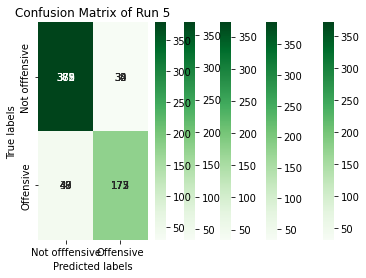

In [ ]:
# prepare cross validation
n=5
target_names = ['0, Not offensive', '1, Offensive']
kf = KFold(n_splits=n, random_state=1, shuffle=True)

index_count = 0

for train_index, val_index in kf.split(data):
  print(F"Loop Number: {index_count+1}")
  index_count += 1
    # splitting Dataframe (dataset not included)
  train_df = data.iloc[train_index]
  val_df = data.iloc[val_index]
    # Defining Model
  model = ClassificationModel(model_type, model_name, num_labels=label_count,args=train_args,use_cuda=cuda_available)
    # train the model
  model.train_model(train_df)
    # validate the model and save results
  result, model_outputs, wrong_predictions = model.eval_model(test, acc=accuracy_score, recall=recall_multiclass, precision=p_multiclass, bal_acc=balanced_accuracy_score, f1=f1_multiclass, prfs=precision_recall_fscore_support)
  prepare_results(result)
  result_df = dict_to_df(result)
  result_df = result_df.sort_values(0)
  result_df.to_csv(F"kfold_result_{trained_model}_{ansatz}{index_count}.csv")
  
    # Print Classification Report and create Confusion Matrix
  print(classification_report(np.argmax(model_outputs, axis = 1), test.task_1.values,target_names=target_names))
  cm = confusion_matrix(np.argmax(model_outputs, axis = 1), test.task_1.values)
  ax = plt.subplot()
  cm_plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title(F'Confusion Matrix of Run {index_count}'); 
  ax.xaxis.set_ticklabels(['Not offfensive', 'Offensive']); ax.yaxis.set_ticklabels(['Not offfensive', 'Offensive']);
  cm_plot.figure.savefig(F"confusion_matrix_{trained_model}_{ansatz}{index_count}.png")

In [ ]:
import time
# sleep to allow to download more files at once

In [ ]:
# download all result files
files.download(F"kfold_result_{trained_model}_{ansatz}1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
time.sleep(5)

In [ ]:
files.download(F"kfold_result_{trained_model}_{ansatz}2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
time.sleep(5)

In [ ]:
files.download(F"kfold_result_{trained_model}_{ansatz}3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
time.sleep(5)

In [ ]:
files.download(F"kfold_result_{trained_model}_{ansatz}4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
time.sleep(5)

In [ ]:
files.download(F"kfold_result_{trained_model}_{ansatz}5.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
file1 = pd.read_csv(F"kfold_result_{trained_model}_{ansatz}1.csv")
file2 = pd.read_csv(F"kfold_result_{trained_model}_{ansatz}2.csv")
file3 = pd.read_csv(F"kfold_result_{trained_model}_{ansatz}3.csv")
file4 = pd.read_csv(F"kfold_result_{trained_model}_{ansatz}4.csv")
file5 = pd.read_csv(F"kfold_result_{trained_model}_{ansatz}5.csv")

file2.head()

,0,1
0,acc,0.891200
1,auprc,0.886652
2,auroc,0.919712
3,bal_acc,0.875985
4,eval_loss,0.359228


In [ ]:
from functools import reduce

names = file1["0"].tolist()
results = reduce(lambda a, b: a.add(b, fill_value=0), [file1["1"], file2["1"], file3["1"], file4["1"], file5["1"]]).tolist()

results_divided = []
for i in results:
  res = i/5
  results_divided.append(res)

d = {'Metrics':names,'Overall Results':results_divided}
overall_df = pd.DataFrame(d)
overall_df


,Metrics,Overall Results
0,acc,0.878400
1,auprc,0.876370
2,auroc,0.921068
3,bal_acc,0.868854
4,eval_loss,0.363413
5,f1_macro,0.864414
6,f1_micro,0.878400
7,f1_score_class_0,0.907940
8,f1_score_class_1,0.820888
9,f1_weighted,0.879109


In [ ]:
overall_df.to_csv(F"overall_kfold_result_{trained_model}_{ansatz}.csv", encoding="utf-8")

In [ ]:
files.download(F"overall_kfold_result_{trained_model}_{ansatz}.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
time.sleep(5)
files.download(F"confusion_matrix_{trained_model}_{ansatz}1.png")
time.sleep(5)
files.download(F"confusion_matrix_{trained_model}_{ansatz}2.png")
time.sleep(5)
files.download(F"confusion_matrix_{trained_model}_{ansatz}3.png")
time.sleep(5)
files.download(F"confusion_matrix_{trained_model}_{ansatz}4.png")
time.sleep(5)
files.download(F"confusion_matrix_{trained_model}_{ansatz}5.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>